<H1>Implementation of clustering algorithm (Regional and Online Learnable Fields)</H1>

<H3>
    See: https://ieeexplore.ieee.org/document/1380021
    <br>
    Or: https://www.researchgate.net/publication/225636930_Regional_and_Online_Learnable_Fields
</H3>

<H3>
    This implementation also includes the following enhancements:<br>
    * Scikit-Learn API<br>
    * Partial Fit (online learning)<br>
    * Cluster ID stability between partial fits<br>
    * Perceptive Field Pruning to reduce model complexity after each fit call
</H3>

![image-caption](ROLF.jpg)

Test data:
[[ 10.47504421   9.9243214 ]
 [ -9.02204385  -9.80495334]
 [-10.17671587 -10.80823709]
 [  9.77223375  10.00873958]
 [ 10.23283122   9.23187816]
 [ -9.92174673  -9.88390948]
 [ 20.65956844 -20.44120941]
 [ 19.33389417 -20.98431234]
 [-10.27143074  -9.79197498]
 [ 10.33614738  10.20373092]
 [ 20.47123406 -20.13379737]
 [  9.94839057  10.20529925]
 [  9.65271607   9.92518273]
 [ 18.88019797 -19.79925047]
 [ 10.26163833   9.91422683]
 [ 19.87899009 -19.24086941]
 [ 19.74124048 -20.48941493]
 [ 19.71534397 -19.86504782]
 [ 19.80238551 -20.57971026]
 [ 19.51444771 -19.8425914 ]
 [ 10.38051886  10.06083751]
 [  9.42626567   9.78108998]
 [  9.74517391   9.78096285]
 [  9.78242322  10.92463186]
 [ 19.76657723 -20.70845306]
 [  9.82604393  10.07817448]
 [ 20.1854125  -19.9289691 ]
 [-10.15450648 -10.8380019 ]
 [ 20.4002824  -19.96086991]
 [ -9.85682816  -9.69557808]
 [-10.00784106  -9.91953592]
 [ 20.01850286 -19.6160488 ]
 [  9.44780833  10.02608254]
 [-10.09532675 -10.19742476]
 [ 

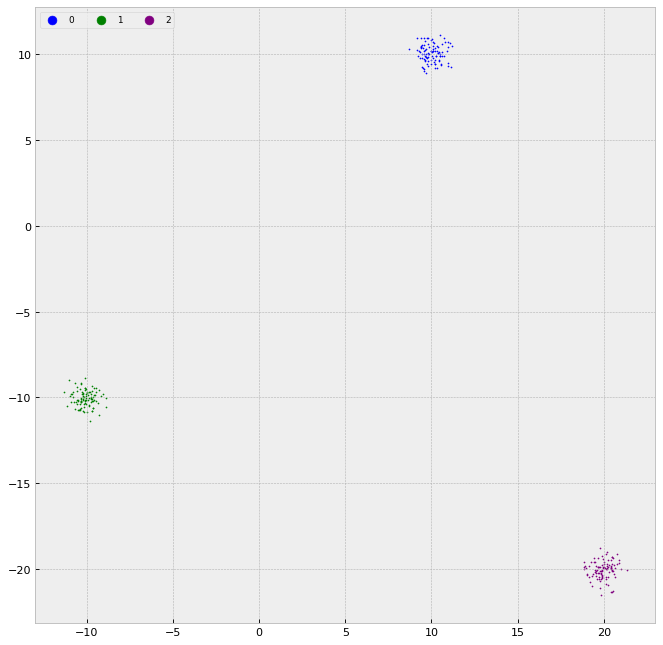

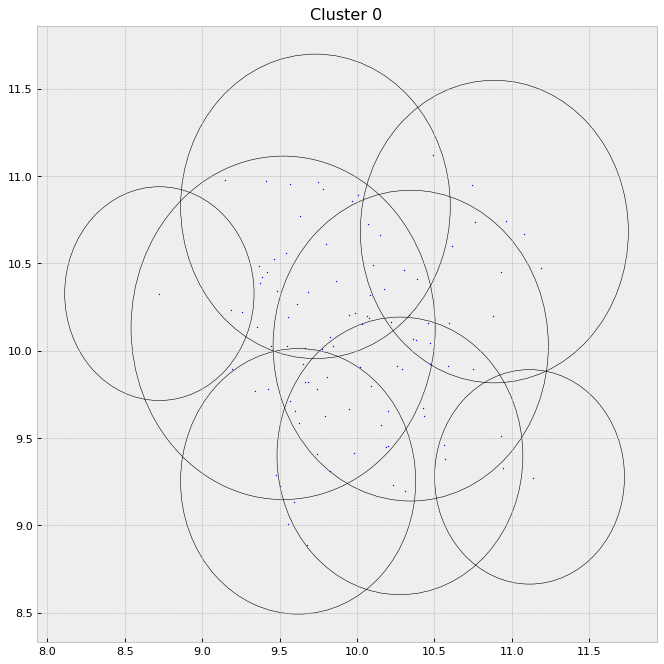

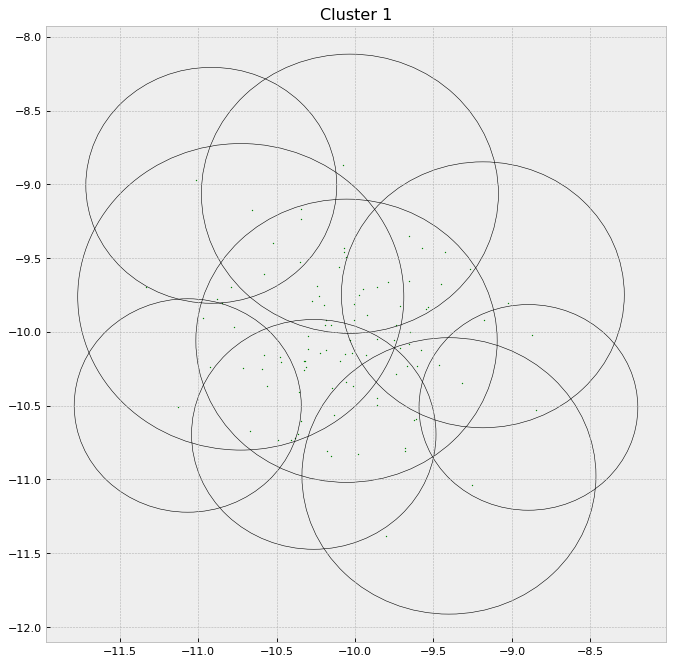

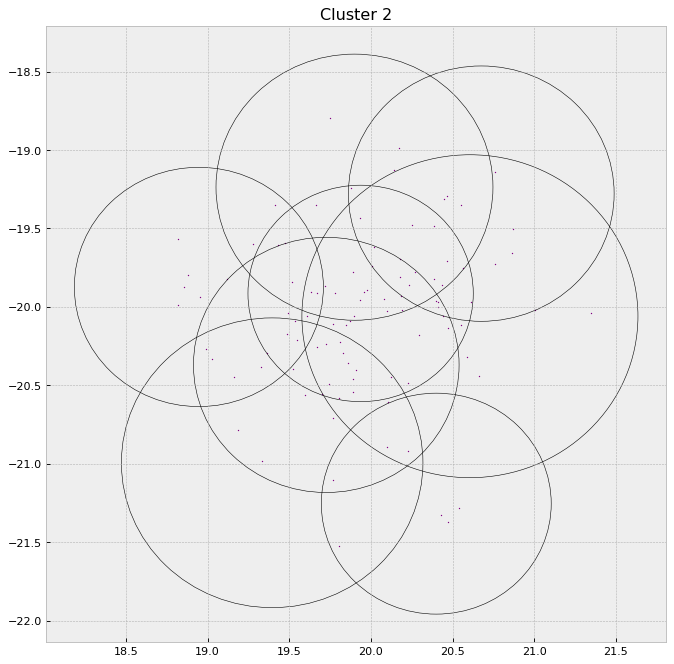

** partial_fit test *************************************************************
Describe X min: -21.523071527399964 max: 21.34811202628179 mean: -0.027475264712674655
Pre Partial Fit [0, 1, 2]
Describe partial_X c1 ( 0 ) min: 7.514584858837666 max: 12.364545281088768 mean: 9.855482897234078
Describe partial_X c2 ( 0 ) min: 7.613851926410107 max: 12.550899083784083 mean: 10.060034171780257
Perceptive Field Count Pre-Prune 32
prune [0, 3, 4, 16] from cluster 0
Perceptive Field Count Post-Prune 28
Describe partial_X c1 ( 1 ) min: -12.925310763173293 max: -7.6531134236549345 mean: -10.181860028537423
Describe partial_X c2 ( 1 ) min: -12.608268148405848 max: -7.847956165698086 mean: -10.100900669450672
Perceptive Field Count Pre-Prune 37
prune [0, 1, 2, 10, 13] from cluster 1
Perceptive Field Count Post-Prune 32
Describe partial_X c1 ( 2 ) min: 16.942509165639446 max: 22.098221788384816 mean: 19.81307706998646
Describe partial_X c2 ( 2 ) min: -22.784102471143438 max: -17.470701772841018 m

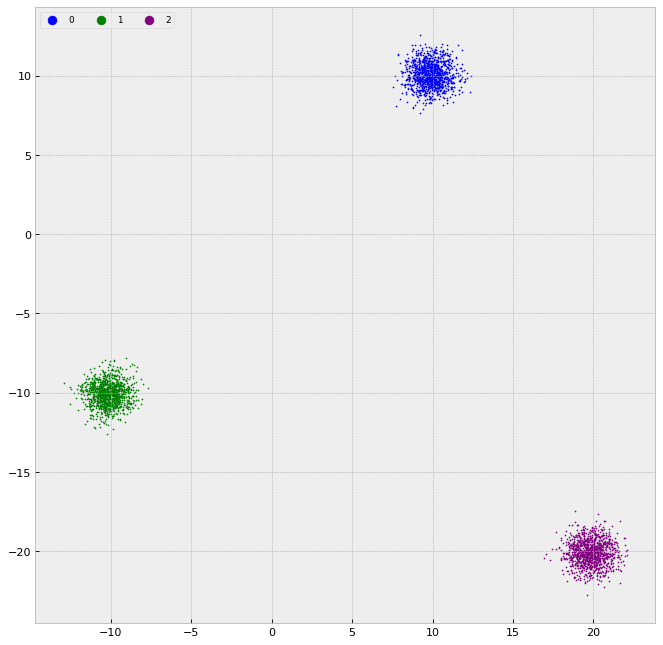

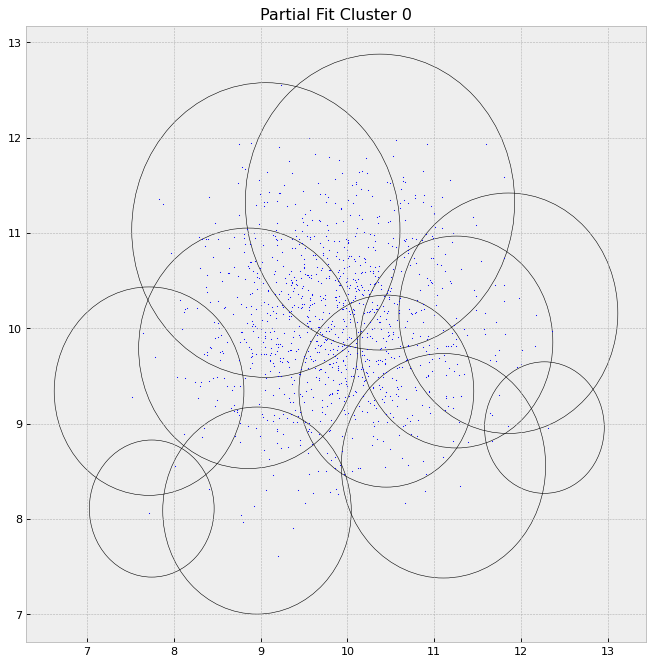

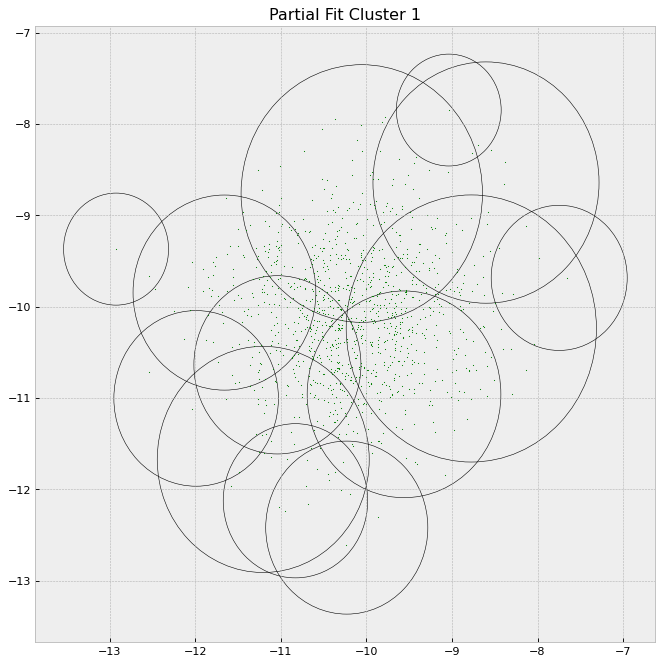

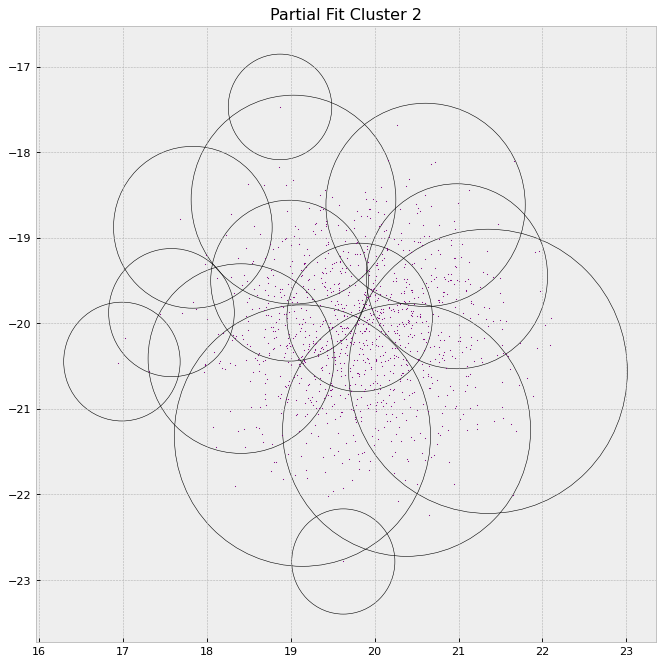

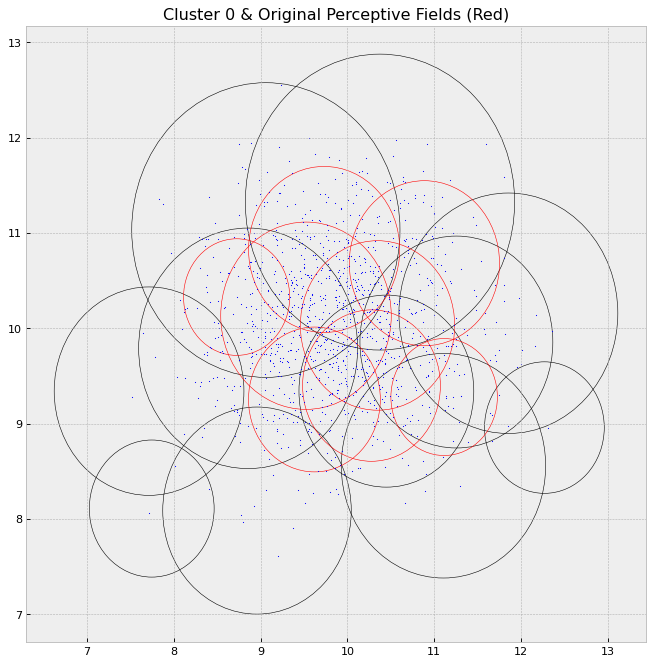

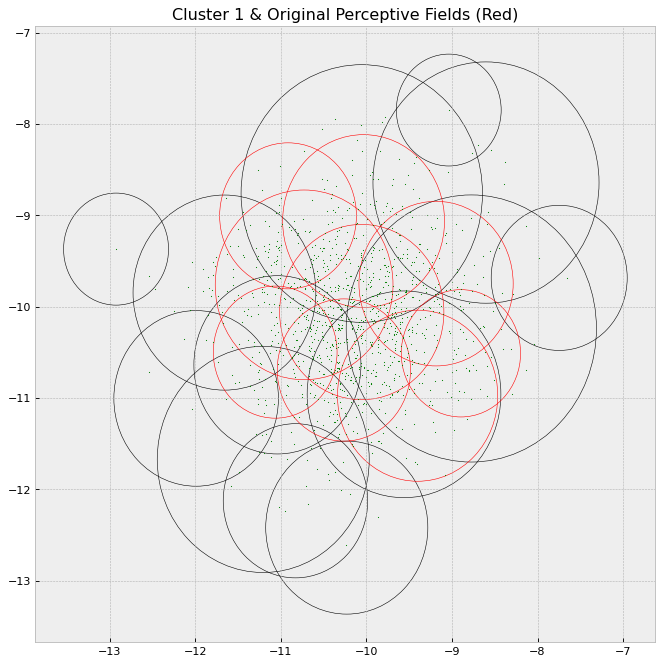

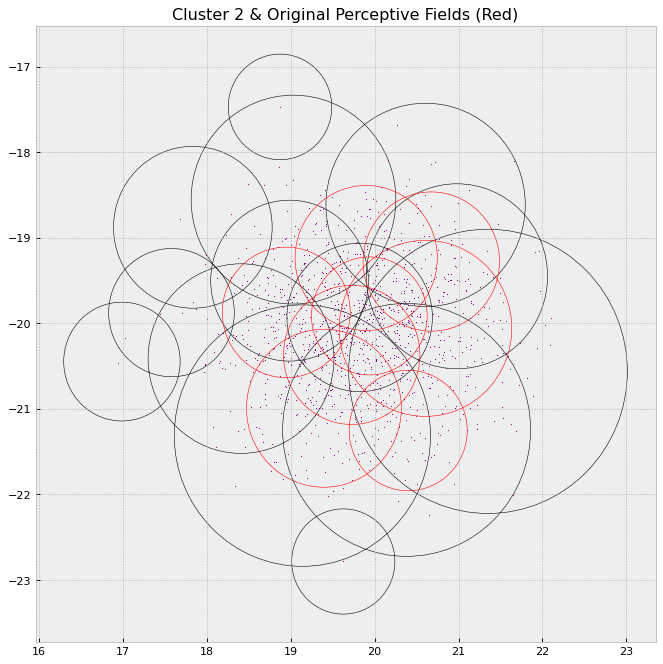

In [1]:
#!/usr/bin/env python
"""
Implementation of clustering algorithm (Regional and Online Learnable Fields)
See: https://ieeexplore.ieee.org/document/1380021
This implementation also includes the following enhancements:
* Scikit-Learn API
* Partial Fit (online learning)
* Cluster ID stability between partial fits
* Perceptive Field Pruning to reduce model complexity after each fit call
"""
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import copy
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

__author__ = "Gerald Gibson Jr"
__copyright__ = "Copyright 2022, Gerald Gibson Jr"
__license__ = "GPLv3"
__version__ = "1.0.0"

class RegionalOnlineLearnableFields:
    def __init__(self, initialRadius=1, radii_calc='constant', perceptive_area_multiplier=1.5, center_learning_rate=0.1,
                 radii_learning_rate=0.1, node_max_separation_threshold=0, prune=False):
        self.cluster_ids = None
        self.perceptive_field_center_locations = None
        self.perceptive_field_center_radii = None
        self.initialRadius = initialRadius
        self.radii_calc = radii_calc
        self.radii_calc_func = {
            'constant': (lambda: self.initialRadius),
            'min': (lambda: np.min(self.perceptive_field_center_radii)),
            'max': (lambda: np.max(self.perceptive_field_center_radii)),
            'mean': (lambda: np.mean(self.perceptive_field_center_radii)),
            'median': (lambda: np.median(self.perceptive_field_center_radii))
        }
        self.perceptive_area_multiplier = perceptive_area_multiplier
        self.center_learning_rate = center_learning_rate
        self.radii_learning_rate = radii_learning_rate
        self.node_max_separation_threshold = node_max_separation_threshold
        self.prune = prune
        self.prepartial_fieldcount = 0

    def learn_perceptive_fields(self, X, partial=False):
        if X is list:
            X = np.asarray(X)

        current = 1

        radius_init_func = self.radii_calc_func[self.radii_calc]

        if partial == False:
            # Initialize the length of the locations and radii arrays as if each data point could get it's own perceptive field
            # We will truncate these arrays after looping over all the data points to be only the same length as the number of perceptive fields learned
            self.perceptive_field_center_locations = np.zeros(X.shape)
            self.perceptive_field_center_radii = np.ones(X.shape[0]) * self.initialRadius
            # Start off with the first data point as the location of the first perceptive field
            self.perceptive_field_center_locations[0] = X[0]
        else:
            current = len(self.perceptive_field_center_locations)
            self.prepartial_fieldcount = current
            self.perceptive_field_center_locations = np.concatenate(
                (self.perceptive_field_center_locations, np.zeros(X.shape)))
            self.perceptive_field_center_radii = np.concatenate(
                (self.perceptive_field_center_radii, np.ones(X.shape[0]) * self.initialRadius))

        for x in X:
            # Determine distance between the data point x and the location of each perceptive field center
            # After doing the subtraction between each perceptive field location value and each value in the data point row
            # we can end up with negative values. If we simply summed up the values to get a final distance these negative values
            # would make the result incorrect. To get around this problem we use np.linalg.norm to calc the Euclidean Distance:
            # (square each value to get rid of the negatives, then sum, then square-root to undo the multiplicative effect of squaring)
            distance = np.linalg.norm(self.perceptive_field_center_locations[:current] - x, axis=1)
            # Get indexes of which perceptive fields overlap the data point
            receptive_fields = \
            np.where(distance <= self.perceptive_field_center_radii[:current] * self.perceptive_area_multiplier)[0]
            if len(receptive_fields) > 0:
                # If the data point falls within the perceptive area of multiple perceptive fields select one and adjust the location and radius
                closest = receptive_fields[np.argmin(distance[receptive_fields])]
                self.perceptive_field_center_locations[closest] += self.center_learning_rate * (
                        x - self.perceptive_field_center_locations[closest])
                self.perceptive_field_center_radii[closest] += self.radii_learning_rate * (
                        distance[closest] - self.perceptive_field_center_radii[closest])
            else:
                # If the data point does not overlap any perceptive field then create a new perceptive field
                self.perceptive_field_center_locations[current] = x
                self.perceptive_field_center_radii[current] = radius_init_func()
                current += 1

        # Truncate the locations and radii arrays to get rid of the unused slots
        self.perceptive_field_center_locations = self.perceptive_field_center_locations[:current]
        self.perceptive_field_center_radii = self.perceptive_field_center_radii[:current]

    def learn_graph_connectivity(self, partial=False):

        if partial is False:
            cluster_id = 0
            perceptive_field_count = len(self.perceptive_field_center_locations)
            nodes = list(np.arange(0, perceptive_field_count))
            self.cluster_ids = np.zeros(perceptive_field_count, dtype=int)
            # Perceptive fields are represented as nodes in a graph.
            # Loop over each and find the edges between the nodes
            # Each subgraph of perceptive fields becomes a cluster
            while nodes:
                edge_search = [nodes[0]]
                nodes.remove(nodes[0])
                while edge_search:
                    current_node = edge_search.pop()
                    self.cluster_ids[current_node] = cluster_id

                    # Calc the distance between the current perceptive field center and each other perceptive field
                    nodes_centers_distance = np.linalg.norm(
                        self.perceptive_field_center_locations[current_node] -
                        self.perceptive_field_center_locations[nodes], axis=1)

                    # Subtract the radii lengths between the current and each other perceptive fields from the distances
                    areas = self.perceptive_field_center_radii[current_node] + self.perceptive_field_center_radii[nodes]
                    areas *= self.perceptive_area_multiplier
                    nodes_areas_distance = nodes_centers_distance - areas

                    # Filter down to the perceptive fields that are close enough to be overlapping
                    overlapping_nodes = np.where(nodes_areas_distance <= self.node_max_separation_threshold)[0]

                    # Update nodes and edges to search
                    if overlapping_nodes.any():
                        nextItems = np.take(nodes, overlapping_nodes).tolist()
                        edge_search += nextItems
                        nodes = list(set(nodes) - set(nextItems))

                # Move to next cluster to find
                cluster_id += 1
        else:
            perceptive_field_count = len(self.perceptive_field_center_locations)
            nodes = list(np.arange(self.prepartial_fieldcount, perceptive_field_count))
            self.cluster_ids = np.concatenate((self.cluster_ids, np.ones(len(nodes), dtype=int) * -1))
            cluster_id = np.max(self.cluster_ids)
            while nodes:
                current_node = nodes.pop(0)

                # Calc the distance between the current perceptive field center and each other perceptive field
                # up to but not including (so as not compare to itself) that same item in the list.
                nodes_centers_distance = np.linalg.norm(
                    self.perceptive_field_center_locations[current_node] -
                    self.perceptive_field_center_locations[:current_node], axis=1)

                # Subtract the radii lengths between the current and each other perceptive fields from the distances
                areas = self.perceptive_field_center_radii[current_node] + self.perceptive_field_center_radii[:current_node]
                areas *= self.perceptive_area_multiplier
                nodes_areas_distance = nodes_centers_distance - areas
                closestidx = np.argmin(nodes_areas_distance)
                if nodes_areas_distance[closestidx] <= self.node_max_separation_threshold:
                    # The closest node is within the threshold so this new field should join the same cluster
                    self.cluster_ids[current_node] = self.cluster_ids[closestidx]
                else:
                    # Add new cluster
                    cluster_id = cluster_id + 1
                    self.cluster_ids[current_node] = cluster_id




    def pruneModel(self, X):
        preds = np.array([self.predict(x, return_perceptive_fields=False) for x in X], dtype=object)
        cluster_ids = set(self.cluster_ids)
        if len(preds.shape) == 1:
            cluster_points = {id: X[preds == id] for id in cluster_ids}
        elif len(preds.shape) == 2:
            cluster_points = {id: X[preds[:, 0] == id] for id in cluster_ids}
        # Loop over each cluster
        for key in cluster_points.keys():
            perceptive_field_indexs_to_remove = []
            # Get all the points for the cluster
            data_points = cluster_points[key]
            if len(data_points) == 0:
                continue
            # Get the index of each perceptive field for the cluster
            perceptive_field_idxs = np.where(self.cluster_ids == key)[0]
            # Fields already checked / pruned do not need to be looped over again and so skip them
            skip_perceptive_field_idxs = []
            # For each perceptive field look to see if all data points in that field also exists in other fields
            for perceptive_field_idx in perceptive_field_idxs:
                if perceptive_field_idx in skip_perceptive_field_idxs:
                    continue
                skip_perceptive_field_idxs.append(perceptive_field_idx)
                perceptive_field_data_points = []
                # Loop over all data points in the cluster to see which ones are within this perceptive field
                for x in data_points:
                    distance = np.linalg.norm(self.perceptive_field_center_locations[perceptive_field_idx] - x)
                    is_within = distance <= self.perceptive_field_center_radii[
                        perceptive_field_idx] * self.perceptive_area_multiplier
                    if is_within:
                        # Store all data points that are within this perceptive field
                        perceptive_field_data_points.append(x)

                data_points_found_again = 0
                for i, x in enumerate(perceptive_field_data_points):
                    # Loop through all other fields to see if this data point is within more than one field
                    for other_perceptive_field_idx in perceptive_field_idxs:
                        # Skip if this is the same field as above
                        if other_perceptive_field_idx in skip_perceptive_field_idxs:
                            continue
                        distance = np.linalg.norm(
                            self.perceptive_field_center_locations[other_perceptive_field_idx] - x)
                        is_within = distance <= self.perceptive_field_center_radii[
                            other_perceptive_field_idx] * self.perceptive_area_multiplier
                        if is_within:
                            data_points_found_again += 1
                            # break out of this loop after finding one other field overlapping this data point
                            break
                # If all of the data points were found again in other fields then this current field can be pruned
                if len(perceptive_field_data_points) == data_points_found_again:
                    skip_perceptive_field_idxs.append(perceptive_field_idx)
                    perceptive_field_indexs_to_remove.append(perceptive_field_idx)

            # Now before moving onto the next cluster prune perceptive fields not needed to cover all data points`
            if len(perceptive_field_indexs_to_remove) > 0:
                print("prune", perceptive_field_indexs_to_remove, "from cluster", key)
                self.perceptive_field_center_locations = np.delete(self.perceptive_field_center_locations,
                                                                   perceptive_field_indexs_to_remove, axis=0)
                self.perceptive_field_center_radii = np.delete(self.perceptive_field_center_radii,
                                                               perceptive_field_indexs_to_remove)
                self.cluster_ids = np.delete(self.cluster_ids,
                                                               perceptive_field_indexs_to_remove)



    def fit(self, X):
        self.learn_perceptive_fields(X)
        self.learn_graph_connectivity()
        print('Perceptive Field Count Pre-Prune', len(self.cluster_ids))
        if self.prune:
            self.pruneModel(X)
        print('Perceptive Field Count Post-Prune', len(self.cluster_ids))

    def partial_fit(self, X, initialRadius=None, radii_calc=None, perceptive_area_multiplier=None,
                    center_learning_rate=None, radii_learning_rate=None, prune=None):
        self.initialRadius = self.initialRadius if initialRadius is None else initialRadius
        self.radii_calc = self.radii_calc if radii_calc is None else radii_calc
        self.perceptive_area_multiplier = self.perceptive_area_multiplier if perceptive_area_multiplier is None else perceptive_area_multiplier
        self.center_learning_rate = self.center_learning_rate if center_learning_rate is None else center_learning_rate
        self.radii_learning_rate = self.radii_learning_rate if radii_learning_rate is None else radii_learning_rate
        self.prune = self.prune if prune is None else prune
        self.learn_perceptive_fields(X, partial=True)
        self.learn_graph_connectivity(partial=True)
        print('Perceptive Field Count Pre-Prune', len(self.cluster_ids))
        if self.prune:
            self.pruneModel(X)
        print('Perceptive Field Count Post-Prune', len(self.cluster_ids))

    def predict(self, x, return_perceptive_fields=False):
        outlier = -1
        distance = np.linalg.norm(self.perceptive_field_center_locations - x, axis=1)
        match = np.where(distance <= self.perceptive_field_center_radii * self.perceptive_area_multiplier)[0]
        if match.size == 0:
            return outlier
        else:
            if return_perceptive_fields:
                return (self.cluster_ids[match[0]], match)
            else:
                return self.cluster_ids[match[0]]


# Generate test data

centers = [[10, 10], [-10, -10], [20, -20]]
X, labels_true = make_blobs(
    n_samples=300, centers=centers, cluster_std=0.5, random_state=0
)

# Define a cluster classifier
rolf = RegionalOnlineLearnableFields(perceptive_area_multiplier=3, radii_calc='mean', initialRadius=0.2,
                                     node_max_separation_threshold=10, prune=False)

print('Test data:')
print(X)

# Fit the model to the data
rolf.fit(X)

print(rolf.cluster_ids)
print(rolf.perceptive_area_multiplier)

# Test the predict method with all the same data
preds = np.array([rolf.predict(x) for x in X])

# Print results of the predictions

print(preds)
print(Counter(preds))

# Break the data out into a dictionary keyed by cluster id
cluster_ids = set(rolf.cluster_ids)
cluster_points = {id: X[preds == id] for id in cluster_ids}
outliers = X[preds == -1]




# Plot the clusters found and the perceptive fields covering the clusters
plt.style.use(['bmh'])

# Create a list of colors that do not include white to black
colors = [c for c in list(mcolors.CSS4_COLORS.values()) if '0000' not in c]
colors = ['b', 'g', 'purple', 'c'] + np.random.choice(colors, len(cluster_ids)).tolist()
plot_points = []
# Plot the data points for all clusters
figure(figsize=(10, 10), dpi=80)
for k in cluster_points.keys():
    plot_points.append(plt.scatter(cluster_points[k][:, 0], cluster_points[k][:, 1], c=colors[k], s=1))

# Plot outliers
#plot_points.append(plt.scatter(outliers[:, 0], outliers[:, 1], marker='x', c='r', s=5))

plt.legend(plot_points,
           cluster_points.keys(),
           scatterpoints=1,
           loc='upper left',
           ncol=3,
           fontsize=8,
           markerscale=8)
plt.show()

# Make a copy of the original perceptive field properties so we can plot them later with the updated model
original_perceptive_field_center_locations_for_cluster = copy.deepcopy(rolf.perceptive_field_center_locations)
original_perceptive_field_center_radii_for_cluster = copy.deepcopy(rolf.perceptive_field_center_radii)
original_cluster_ids = copy.deepcopy(rolf.cluster_ids)

# Plot single clusters
for k in cluster_ids:
    figure(figsize=(10, 10), dpi=80)
    plt.title('Cluster ' + str(k))
    plt.scatter(cluster_points[k][:, 0], cluster_points[k][:, 1], marker='.', c=colors[k], s=2)
    # Plot outliers
    #plt.scatter(outliers[:, 0], outliers[:, 1], marker='x', c='r', s=5)

    # Plot the perceptive fields on top of the data points
    perceptive_field_center_locations_for_cluster = rolf.perceptive_field_center_locations[rolf.cluster_ids == k]
    perceptive_field_center_radii_for_cluster = rolf.perceptive_field_center_radii[
                                                    rolf.cluster_ids == k] * rolf.perceptive_area_multiplier

    for i in np.arange(len(perceptive_field_center_locations_for_cluster)):
        location = perceptive_field_center_locations_for_cluster[i]
        radius = perceptive_field_center_radii_for_cluster[i]
        circle = plt.Circle((location[0], location[1]), radius, color='black', fill=False)
        plt.gca().add_patch(circle)
    plt.show()

#exit()

# Next generate more test data near the existing clusters and partial_fit this new data
# ** partial_fit test *************************************************************
print('** partial_fit test *************************************************************')

print('Describe X', 'min:', X.min(), 'max:', X.max(), 'mean:', X.mean())

# MinMaxScaler will be used to generate data within a range
# Generate new data points randomly around the existing clustered data points
scaler = MinMaxScaler(feature_range=(-2, 2))
addX1 = scaler.fit_transform(np.random.standard_normal(1000).reshape(-1, 1))
addX2 = scaler.fit_transform(np.random.standard_normal(1000).reshape(-1, 1))

# Loop over each cluster and generate data in the same general area
new_cluster_points = {}
for k in cluster_points.keys():
    c1 = (np.random.choice(cluster_points[k][:, 0], size=1000) + addX1.ravel()).tolist()
    c2 = (np.random.choice(cluster_points[k][:, 1], size=1000) + addX2.ravel()).tolist()
    new_cluster_points[k] = np.reshape(list(zip(c1, c2)), (1000, 2))

print('Pre Partial Fit', sorted(set(rolf.cluster_ids)))

# Partial fit the new data to the existing model
for key, partial_X in new_cluster_points.items():
    print('Describe partial_X c1 (', key, ')', 'min:', partial_X[:, 0].min(), 'max:', partial_X[:, 0].max(), 'mean:',
          partial_X[:, 0].mean())
    print('Describe partial_X c2 (', key, ')', 'min:', partial_X[:, 1].min(), 'max:', partial_X[:, 1].max(), 'mean:',
          partial_X[:, 1].mean())
    rolf.partial_fit(partial_X, prune=True)

print('Post Partial Fit', sorted(set(rolf.cluster_ids)))

# Combine all the new partial fit data with the original modeled data
newX = np.concatenate(list(new_cluster_points.values()))
X = np.concatenate((X, newX))
# Predict which cluster all data points belong to
preds = np.array([rolf.predict(x) for x in X])
cluster_ids = set(rolf.cluster_ids)
# Break the data points out by cluster id into a dictionary
cluster_points = {id: X[preds == id] for id in cluster_ids}
# Get outliers
outliers = X[preds == -1]

# Generate a list of colors to use for all clusters
colors = [c for c in list(mcolors.CSS4_COLORS.values()) if '0000' not in c]
colors = ['b', 'g', 'purple', 'c'] + np.random.choice(colors, len(cluster_ids)).tolist()
plot_points = []
# Plot the data points for all the updated clusters
figure(figsize=(10, 10), dpi=80)
for k in cluster_points.keys():
    plot_points.append(plt.scatter(cluster_points[k][:, 0], cluster_points[k][:, 1], c=colors[k], s=1))

# Plot outliers
#plot_points.append(plt.scatter(outliers[:, 0], outliers[:, 1], marker='x', c='r', s=5))

plt.legend(plot_points,
           cluster_points.keys(),
           scatterpoints=1,
           loc='upper left',
           ncol=3,
           fontsize=8,
           markerscale=8)
plt.show()

# Zoom in on specific cluster without original comparison
for k in cluster_ids:
    figure(figsize=(10, 10), dpi=80)
    plt.title('Partial Fit Cluster ' + str(k))

    # Plot outliers
    #plt.scatter(outliers[:, 0], outliers[:, 1], marker='x', c='r', s=5)

    # Plot perceptive field areas
    perceptive_field_center_locations_for_cluster = rolf.perceptive_field_center_locations[rolf.cluster_ids == k]
    perceptive_field_center_radii_for_cluster = rolf.perceptive_field_center_radii[
                                                    rolf.cluster_ids == k] * rolf.perceptive_area_multiplier

    for i in np.arange(len(perceptive_field_center_locations_for_cluster)):
        location = perceptive_field_center_locations_for_cluster[i]
        radius = perceptive_field_center_radii_for_cluster[i]
        circle = plt.Circle((location[0], location[1]), radius, color='black', fill=False)
        plt.gca().add_patch(circle)


    # Plot data points
    plt.scatter(cluster_points[k][:, 0], cluster_points[k][:, 1], marker='.', c=colors[k], s=1)

    plt.show()

# Zoom in on specific cluster WITH original comparison
for k in cluster_ids:
    figure(figsize=(10, 10), dpi=80)
    plt.title('Cluster ' + str(k) + ' & Original Perceptive Fields (Red)')

    # Plot outliers
    #plt.scatter(outliers[:, 0], outliers[:, 1], marker='x', c='r', s=5)

    # Plot perceptive field areas
    perceptive_field_center_locations_for_cluster = rolf.perceptive_field_center_locations[rolf.cluster_ids == k]
    perceptive_field_center_radii_for_cluster = rolf.perceptive_field_center_radii[
                                                    rolf.cluster_ids == k] * rolf.perceptive_area_multiplier

    for i in np.arange(len(perceptive_field_center_locations_for_cluster)):
        location = perceptive_field_center_locations_for_cluster[i]
        radius = perceptive_field_center_radii_for_cluster[i]
        circle = plt.Circle((location[0], location[1]), radius, color='black', fill=False)
        plt.gca().add_patch(circle)

    # Plot the original fields in red on top
    k_original_perceptive_field_center_locations_for_cluster = original_perceptive_field_center_locations_for_cluster[original_cluster_ids == k]
    k_original_perceptive_field_center_radii_for_cluster = original_perceptive_field_center_radii_for_cluster[
                                                    original_cluster_ids == k] * rolf.perceptive_area_multiplier
    for i in np.arange(len(k_original_perceptive_field_center_locations_for_cluster)):
        location = k_original_perceptive_field_center_locations_for_cluster[i]
        radius = k_original_perceptive_field_center_radii_for_cluster[i]
        circle = plt.Circle((location[0], location[1]), radius, color='red', fill=False)
        plt.gca().add_patch(circle)


    # Plot data points
    plt.scatter(cluster_points[k][:, 0], cluster_points[k][:, 1], marker='.', c=colors[k], s=1)
    plt.show()
